# Field Detection using Self-Supervised NNCLR

In [1]:
import math
import matplotlib.pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np

import folium
import h3

In [2]:
from pathlib import Path
parquet_dir_training = Path('D:\hexes_with_pixels_s2\hex_index_L3=832a89fffffffff')
parquet_dir_validation = Path('D:\hexes_with_pixels_s2\hex_index_L3=832a89fffffffff')

In [3]:
df = pd.concat(
            pd.read_parquet(parquet_file)
            for parquet_file in parquet_dir_training.glob('*.parquet')
         )

display(df.head(5))
print(df.shape)

start_date                          end_date  \
0  2020-07-11T19:25:31.600000+00:00  2021-07-18T22:12:40.268000+00:00   
1  2020-07-11T19:25:31.600000+00:00  2021-07-18T22:12:40.268000+00:00   
2  2020-07-11T19:25:31.600000+00:00  2021-07-18T22:12:40.268000+00:00   
3  2020-07-11T19:25:31.600000+00:00  2021-07-18T22:12:40.268000+00:00   
4  2020-07-11T19:25:31.600000+00:00  2021-07-18T22:12:40.268000+00:00   

                              FIELD_OPERATION_GUID  \
0  07571e4f-0822-4803-aa14-c0cd079e414c 2020-11-08   
1  07571e4f-0822-4803-aa14-c0cd079e414c 2020-11-08   
2  07571e4f-0822-4803-aa14-c0cd079e414c 2020-11-08   
3  07571e4f-0822-4803-aa14-c0cd079e414c 2020-11-08   
4  07571e4f-0822-4803-aa14-c0cd079e414c 2020-11-08   

                                            scene_id              hex  \
0  S2A_MSIL2A_20200712T155911_N0214_R097_T17SQA_2...  8c2a891134001ff   
1  S2A_MSIL2A_20200712T155911_N0214_R097_T17SQA_2...  8c2a891134003ff   
2  S2A_MSIL2A_20200712T155911_N0214_R097_T17SQA_2...  8c2a891134005ff   
3  S2A_MSIL2A_20200712T155911_N0214_R097_T17SQA_2...  8c2a891134007ff   
4  S2A_MSIL2A_20200712T155911_N0214_R097_T17SQA_2...  8c2a891134009ff   

   SCL_val s2_tile    B01     B02     B03     B04     B05     B06     B07  \
0        4   17SQA  733.0  1005.0  1648.0  1626.0  2284.0  4004.0  4304.0   
1        4   17SQA  733.0   893.0  1566.0  1484.0  1953.0  3775.0  4208.0   
2        4   17SQA  714.0   469.0   911.0   664.0  1527.0  3296.0  3777.0   
3        4   17SQA  714.0   469.0   911.0   664.0  1527.0  3296.0  3777.0   
4        4   17SQA  733.0   937.0  1550.0  1522.0  2450.0  4127.0  4493.0   

      B08     B8A     B09     B11     B12  
0  4352.0  4589.0  4563.0  3291.0  2215.0  
1  4464.0  4457.0  4563.0  3076.0  1952.0  
2  3946.0  4145.0  4273.0  2715.0  1561.0  
3  4052.0  4145.0  4273.0  2715.0  1561.0  
4  4368.0  4633.0  4563.0  3493.0  2380.0

(123663, 19)


In [4]:
center = h3.h3_to_geo_boundary(h=df.iloc[0]['hex'],geo_json=True)

df = df.drop_duplicates(subset='hex', keep="first")

m = folium.Map(location=(center[0][1], center[0][0]),
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                zoom_start=16,
                overlay = False,
                control = True)

for index, row in df.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row['hex'],geo_json=True)]}
    geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'orange', 'color': 'green', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)

m

In [5]:
positive_samples = ['8c2a89113412bff', '8c2a891134069ff', '8c2a8911340cbff', '8c2a891acbb5dff', '8c2a891acba3dff', 
                    '8c2a891aa918bff', '8c2a891a85969ff', '8c2a891aa91abff', '8c2a891aa9619ff', '8c2a891a86e0dff',
                    '8c2a891a839ebff', '8c2a891a88945ff', '8c2a891ac6f07ff', '8c2a891a86e15ff', '8c2a891acba25ff']

negative_samples = ['8c2a891134ad3ff', '8c2a891a8c515ff', '8c2a891a8c509ff', '8c2a891a8c55bff', '8c2a891ae2d19ff', 
                    '8c2a891a86eb7ff', '8c2a891a82a67ff', '8c2a891134ae3ff', '8c2a891a86ccbff', '8c2a891a86ea5ff',
                    '8c2a891a861a1ff', '8c2a891aa9a8bff', '8c2a89113435bff', '8c2a8911358d3ff', '8c2a8911358bbff']

In [6]:
steps_per_epoch = 20
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 50
input_shape = (12,12,1)
width = 256
num_epochs = 100

temperature = 0.1
queue_size = 10000
contrastive_augmenter = { "brightness": 0.9, "name": "contrastive_augmenter", "scale": (0.2, 1.0)}
classification_augmenter = { "brightness": 0.8, "name": "classification_augmenter", "scale": (0.5, 1.0) }

In [7]:
def prepare_dataset():

    df = pd.concat(
            pd.read_parquet(parquet_file)
            for parquet_file in parquet_dir_training.glob('*.parquet')
         )
    
    df['y'] = np.where(np.isin(df['hex'],positive_samples), 1, -1)
    df['y'] = np.where(df['hex'].isin(negative_samples), 0, df['y'])
    
    print('Positive labeled samples:', sum(df.y==1))
    print('Negative labeled samples:', sum(df.y==0))
    print('Unlabeled labeled samples:', sum(df.y==-1))
    
    df_labeled = df[df.y != -1]
    df_unlabeled = df[df.y == -1]
    
    df_labeled = df_labeled[['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12', 'y']].astype('int')
    df_unlabeled = df_unlabeled[['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12', 'y']].astype('int')
    
    df_labeled_X = df_labeled.loc[:,df_labeled.columns != 'y']
    df_labeled_X_array = df_labeled_X.values.reshape(df_labeled_X.shape[0], 4, 3)
    # expand to an image
    df_labeled_X_array = np.resize(df_labeled_X_array, [df_labeled_X_array.shape[0],1,12])
    df_labeled_X_array = np.repeat(df_labeled_X_array, 12, axis=1)
    
    
    df_unlabeled_X = df_unlabeled.loc[:,df_unlabeled.columns != 'y']
    df_unlabeled_X_array = df_unlabeled_X.values.reshape(df_unlabeled_X.shape[0], 4, 3)
    # expand to an image
    df_unlabeled_X_array = np.resize(df_unlabeled_X_array, [df_unlabeled_X_array.shape[0],1,12])
    df_unlabeled_X_array = np.repeat(df_unlabeled_X_array, 12, axis=1)
    
    unlabeled_train_images = df_unlabeled.shape[0]
    labeled_train_images = df_labeled.shape[0]
    
    unlabeled_batch_size = unlabeled_train_images // steps_per_epoch
    labeled_batch_size = labeled_train_images // steps_per_epoch
    batch_size = unlabeled_batch_size + labeled_batch_size
    

    unlabeled_train_dataset = tf.data.Dataset\
        .from_tensor_slices((df_unlabeled_X_array, 
                            df_unlabeled.loc[:,df_unlabeled.columns == 'y'].values.T[0]))\
        .shuffle(50)\
        .batch(50, drop_remainder=True)
    
    labeled_train_dataset = tf.data.Dataset\
        .from_tensor_slices((df_labeled_X_array,
                             df_labeled.loc[:,df_labeled.columns == 'y'].values.T[0]))\
        .shuffle(50)\
        .batch(50, drop_remainder=True)
    
    test_dataset = tf.data.Dataset\
        .from_tensor_slices((df_labeled_X_array,
                             df_labeled.loc[:,df_labeled.columns == 'y'].values.T[0]))\
        .batch(50)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    
   
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset,labeled_train_dataset)
    ).prefetch(buffer_size=AUTOTUNE)

    return batch_size, train_dataset, labeled_train_dataset, test_dataset

    
    
batch_size, train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()
    

Positive labeled samples: 1060
Negative labeled samples: 997
Unlabeled labeled samples: 121606


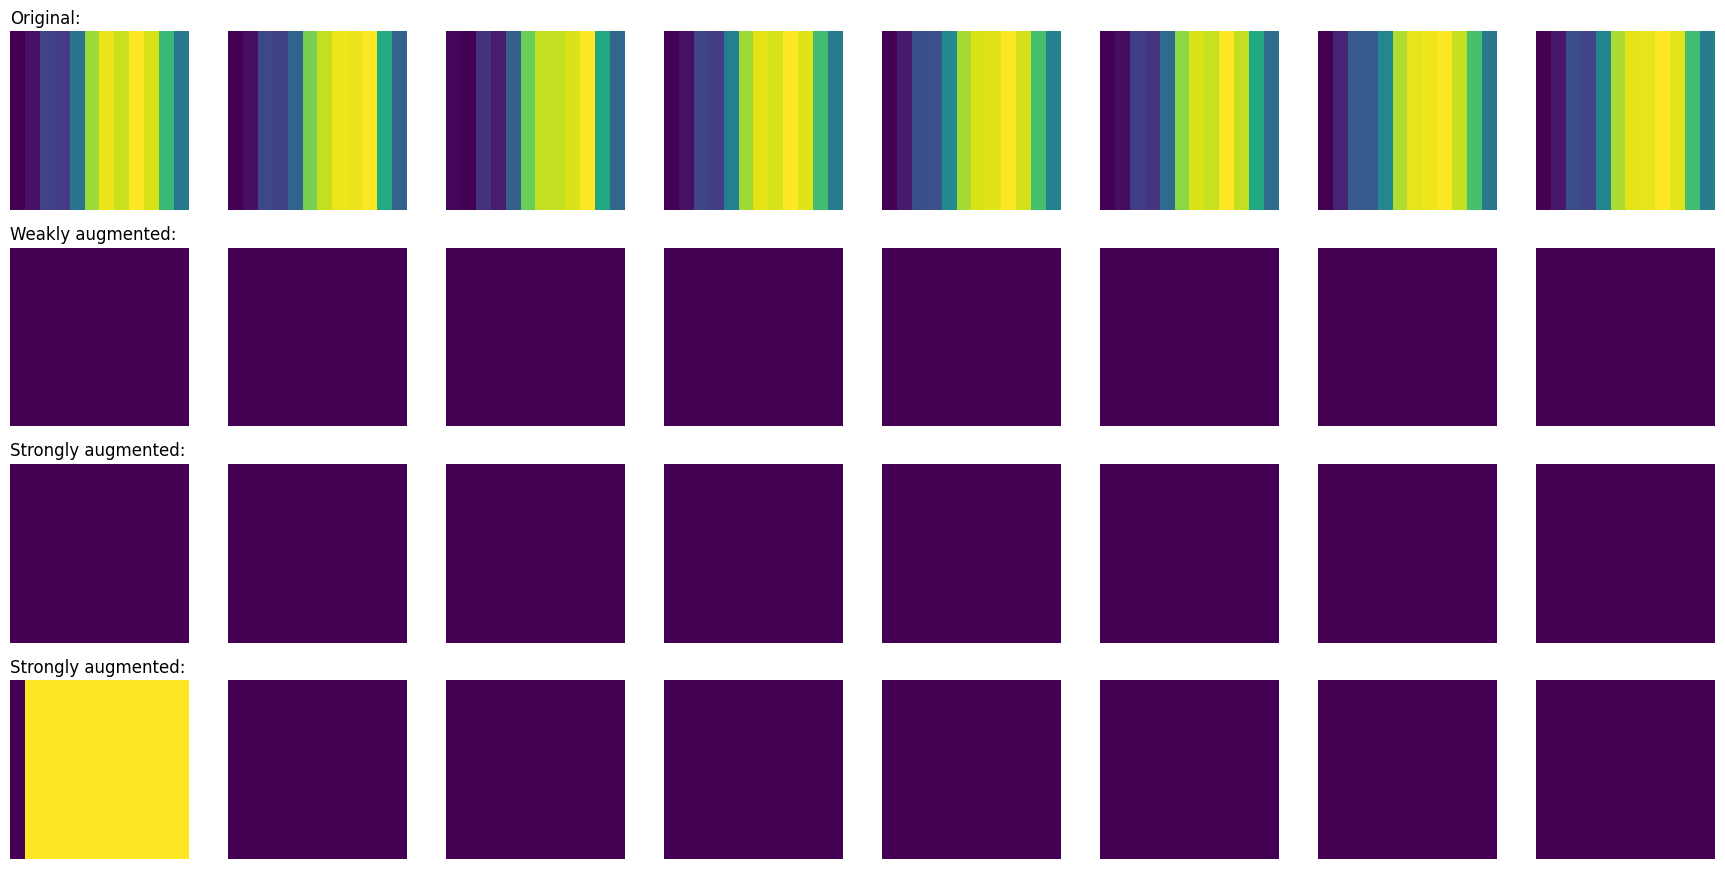

In [8]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super(RandomResizedCrop, self).__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images
      
class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super(RandomBrightness, self).__init__()
        self.brightness = brightness

    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)

    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness
            ),
        )

    def call(self, images):
        images = self.random_brightness(images)
        return images
      
def augmenter(brightness, name, scale):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
            RandomBrightness(brightness=brightness),
        ],
        name=name,
    )

def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        augmenter(**classification_augmenter)(images),
        augmenter(**contrastive_augmenter)(images),
        augmenter(**contrastive_augmenter)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

In [9]:
def encoder():
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Conv2D(width, kernel_size=1, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=1, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=1, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=1, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

In [10]:
class NNCLR(keras.Model):
    def __init__(
        self, temperature, queue_size,
    ):
        super(NNCLR, self).__init__()
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_augmenter = augmenter(**contrastive_augmenter)
        self.classification_augmenter = augmenter(**classification_augmenter)
        self.encoder = encoder()
        self.projection_head = keras.Sequential(
            [
                layers.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(2)], name="linear_probe"
        )
        self.temperature = temperature

        feature_dimensions = self.encoder.output_shape[1]
        
        print('feature_dimensions',feature_dimensions)
        
        self.feature_queue = tf.Variable(
            tf.math.l2_normalize(
                tf.random.normal(shape=(queue_size, feature_dimensions)), axis=1
            ),
            trainable=False,
        )

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super(NNCLR, self).compile(**kwargs)
        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

    def nearest_neighbour(self, projections):
        support_similarities = tf.matmul(
            projections, self.feature_queue, transpose_b=True
        )
        nn_projections = tf.gather(
            self.feature_queue, tf.argmax(support_similarities, axis=1), axis=0
        )
        return projections + tf.stop_gradient(nn_projections - projections)

    def update_contrastive_accuracy(self, features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)

        batch_size = tf.shape(features_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )

    def update_correlation_accuracy(self, features_1, features_2):
        features_1 = (
            features_1 - tf.reduce_mean(features_1, axis=0)
        ) / tf.math.reduce_std(features_1, axis=0)
        features_2 = (
            features_2 - tf.reduce_mean(features_2, axis=0)
        ) / tf.math.reduce_std(features_2, axis=0)

        batch_size = tf.shape(features_1, out_type=tf.float32)[0]
        cross_correlation = (
            tf.matmul(features_1, features_2, transpose_a=True) / batch_size
        )

        feature_dim = tf.shape(features_1)[1]
        correlation_labels = tf.range(feature_dim)
        self.correlation_accuracy.update_state(
            tf.concat([correlation_labels, correlation_labels], axis=0),
            tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0),
        )

    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)

        similarities_1_2_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_1), projections_2, transpose_b=True
            )
            / self.temperature
        )
        similarities_1_2_2 = (
            tf.matmul(
                projections_2, self.nearest_neighbour(projections_1), transpose_b=True
            )
            / self.temperature
        )

        similarities_2_1_1 = (
            tf.matmul(
                self.nearest_neighbour(projections_2), projections_1, transpose_b=True
            )
            / self.temperature
        )
        similarities_2_1_2 = (
            tf.matmul(
                projections_1, self.nearest_neighbour(projections_2), transpose_b=True
            )
            / self.temperature
        )

        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat(
                [
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                ],
                axis=0,
            ),
            tf.concat(
                [
                    similarities_1_2_1,
                    similarities_1_2_2,
                    similarities_2_1_1,
                    similarities_2_1_2,
                ],
                axis=0,
            ),
            from_logits=True,
        )

        self.feature_queue.assign(
            tf.concat([projections_1, self.feature_queue[:-batch_size]], axis=0)
        )
        return loss

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data
        
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)

        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
 
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
        
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
            
            gradients = tape.gradient(
                                contrastive_loss,
                                self.encoder.trainable_weights + self.projection_head.trainable_weights,
                        )
            
            self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.encoder.trainable_weights + self.projection_head.trainable_weights,
                )
            )
        self.update_contrastive_accuracy(features_1, features_2)
        self.update_correlation_accuracy(features_1, features_2)
        preprocessed_images = self.classification_augmenter(labeled_images)

        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            class_logits = self.linear_probe(features)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        
        self.probe_accuracy.update_state(labels, class_logits)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "r_acc": self.correlation_accuracy.result(),
            "p_loss": probe_loss,
            "p_acc": self.probe_accuracy.result(),
        }

    def test_step(self, data):
        labeled_images, labels = data

        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)

        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)

        self.probe_accuracy.update_state(labels, class_logits)
        return {"p_loss": probe_loss, "p_acc": self.probe_accuracy.result()}

In [11]:
model = NNCLR(temperature=temperature, queue_size=queue_size)
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)
pretrain_history = model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)

feature_dimensions 256
Epoch 1/100
41/41 [==============================] - 3s 37ms/step - c_loss: 4.6053 - c_acc: 0.0096 - r_acc: 0.0042 - p_loss: 0.6919 - p_acc: 0.5029 - val_p_loss: 0.6922 - val_p_acc: 0.5187
Epoch 2/100
41/41 [==============================] - 1s 33ms/step - c_loss: 4.6052 - c_acc: 0.0104 - r_acc: 0.0026 - p_loss: 0.6926 - p_acc: 0.5163 - val_p_loss: 0.7004 - val_p_acc: 0.5168
Epoch 3/100
41/41 [==============================] - 1s 33ms/step - c_loss: 4.6052 - c_acc: 0.0105 - r_acc: 0.0025 - p_loss: 0.6925 - p_acc: 0.5065 - val_p_loss: 0.7017 - val_p_acc: 0.5168
Epoch 4/100
41/41 [==============================] - 1s 33ms/step - c_loss: 4.6051 - c_acc: 0.0095 - r_acc: 0.0026 - p_loss: 0.6918 - p_acc: 0.5065 - val_p_loss: 0.7081 - val_p_acc: 0.5153
Epoch 5/100
41/41 [==============================] - 1s 33ms/step - c_loss: 4.6052 - c_acc: 0.0104 - r_acc: 0.0030 - p_loss: 0.6927 - p_acc: 0.5090 - val_p_loss: 0.6980 - val_p_acc: 0.5177
Epoch 6/100
41/41 [=============

41/41 [==============================] - 1s 33ms/step - c_loss: 4.6052 - c_acc: 0.0119 - r_acc: 0.0072 - p_loss: 0.6950 - p_acc: 0.5025 - val_p_loss: 0.6954 - val_p_acc: 0.5668
Epoch 45/100
41/41 [==============================] - 1s 34ms/step - c_loss: 4.6052 - c_acc: 0.0118 - r_acc: 0.0075 - p_loss: 0.6918 - p_acc: 0.5402 - val_p_loss: 0.6832 - val_p_acc: 0.5887
Epoch 46/100
41/41 [==============================] - 1s 33ms/step - c_loss: 4.6052 - c_acc: 0.0110 - r_acc: 0.0064 - p_loss: 0.6944 - p_acc: 0.5050 - val_p_loss: 0.8385 - val_p_acc: 0.5406
Epoch 47/100
41/41 [==============================] - 1s 35ms/step - c_loss: 4.6052 - c_acc: 0.0107 - r_acc: 0.0066 - p_loss: 0.7152 - p_acc: 0.5099 - val_p_loss: 0.7089 - val_p_acc: 0.5649
Epoch 48/100
41/41 [==============================] - 1s 35ms/step - c_loss: 4.6052 - c_acc: 0.0112 - r_acc: 0.0075 - p_loss: 0.6936 - p_acc: 0.5278 - val_p_loss: 0.7044 - val_p_acc: 0.5946
Epoch 49/100
41/41 [==============================] - 1s 35ms/s

41/41 [==============================] - 1s 34ms/step - c_loss: 4.6052 - c_acc: 0.0109 - r_acc: 0.0079 - p_loss: 0.6862 - p_acc: 0.5134 - val_p_loss: 0.6826 - val_p_acc: 0.5975
Epoch 88/100
41/41 [==============================] - 1s 35ms/step - c_loss: 4.6052 - c_acc: 0.0100 - r_acc: 0.0071 - p_loss: 0.6894 - p_acc: 0.5094 - val_p_loss: 0.6901 - val_p_acc: 0.5887
Epoch 89/100
41/41 [==============================] - 1s 35ms/step - c_loss: 4.6051 - c_acc: 0.0100 - r_acc: 0.0081 - p_loss: 0.6940 - p_acc: 0.5083 - val_p_loss: 0.6913 - val_p_acc: 0.5766
Epoch 90/100
41/41 [==============================] - 1s 33ms/step - c_loss: 4.6051 - c_acc: 0.0113 - r_acc: 0.0067 - p_loss: 0.6923 - p_acc: 0.5223 - val_p_loss: 0.6293 - val_p_acc: 0.6004
Epoch 91/100
41/41 [==============================] - 1s 36ms/step - c_loss: 4.6051 - c_acc: 0.0106 - r_acc: 0.0078 - p_loss: 0.6857 - p_acc: 0.5130 - val_p_loss: 0.6887 - val_p_acc: 0.5907
Epoch 92/100
41/41 [==============================] - 1s 34ms/s

In [12]:
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        augmenter(**classification_augmenter),
        model.encoder,
        layers.Dense(2),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)

Epoch 1/100
41/41 [==============================] - 1s 13ms/step - loss: 1.8692 - acc: 0.5107 - val_loss: 0.7242 - val_acc: 0.4847
Epoch 2/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6874 - acc: 0.5356 - val_loss: 0.6753 - val_acc: 0.5775
Epoch 3/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6825 - acc: 0.5376 - val_loss: 0.6658 - val_acc: 0.5824
Epoch 4/100
41/41 [==============================] - 0s 9ms/step - loss: 0.6812 - acc: 0.5429 - val_loss: 0.6659 - val_acc: 0.5834
Epoch 5/100
41/41 [==============================] - 0s 11ms/step - loss: 0.6730 - acc: 0.5468 - val_loss: 0.6567 - val_acc: 0.5921
Epoch 6/100
41/41 [==============================] - 0s 9ms/step - loss: 0.6787 - acc: 0.5376 - val_loss: 0.6555 - val_acc: 0.6028
Epoch 7/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6769 - acc: 0.5532 - val_loss: 0.6557 - val_acc: 0.6033
Epoch 8/100
41/41 [==============================] - 0s 8ms/step - loss: 0.6822 -

Epoch 63/100
41/41 [==============================] - 1s 14ms/step - loss: 0.6767 - acc: 0.5512 - val_loss: 0.6552 - val_acc: 0.6004
Epoch 64/100
41/41 [==============================] - 1s 35ms/step - loss: 0.6765 - acc: 0.5663 - val_loss: 0.6499 - val_acc: 0.6150
Epoch 65/100
41/41 [==============================] - 1s 17ms/step - loss: 0.6726 - acc: 0.5654 - val_loss: 0.6478 - val_acc: 0.6106
Epoch 66/100
41/41 [==============================] - 1s 15ms/step - loss: 0.6780 - acc: 0.5420 - val_loss: 0.6606 - val_acc: 0.5936
Epoch 67/100
41/41 [==============================] - 1s 13ms/step - loss: 0.6732 - acc: 0.5585 - val_loss: 0.6636 - val_acc: 0.5897
Epoch 68/100
41/41 [==============================] - 1s 30ms/step - loss: 0.6721 - acc: 0.5639 - val_loss: 0.6590 - val_acc: 0.5892
Epoch 69/100
41/41 [==============================] - 1s 15ms/step - loss: 0.6739 - acc: 0.5571 - val_loss: 0.6624 - val_acc: 0.5955
Epoch 70/100
41/41 [==============================] - 1s 15ms/step - 

In [13]:
df_validation = pd.concat(
            pd.read_parquet(parquet_file)
            for parquet_file in parquet_dir_validation.glob('*.parquet')
         )

print(df_validation.shape)

df_validation = df_validation.drop_duplicates(subset='hex', keep="first")

df_hexes = df_validation[['hex']]

df_validation = df_validation[['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']].astype('int')

predict_x = finetuning_model.predict(test_dataset)
classes_x = np.argmax(predict_x,axis=1)
print(sum(classes_x==0),sum(classes_x==1))

df_classes = pd.DataFrame(classes_x, columns=['class'])

df_hexes = df_hexes.reset_index(drop=True)
df_classes = df_classes.reset_index(drop=True)

df_predict = pd.concat([df_hexes,df_classes], axis=1)

center = h3.h3_to_geo_boundary(h=df_predict.iloc[0]['hex'],geo_json=True)

m = folium.Map(location=(center[0][1], center[0][0]),
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True)

for index, row in df_predict.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=str(row['hex']),geo_json=True)]}
    
    if row['class'] == 1:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'orange', 'color': 'green', 'weight': 0.5})
    else:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'blue', 'color': 'red', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)

m

(123663, 19)
42/42 [==============================] - 1s 12ms/step
275 1782


ValueError: invalid literal for int() with base 16: 'nan'

In [ ]:
def print_hexes(hexes):
    center = h3.h3_to_geo_boundary(h=hexes[0],geo_json=True)

    m = folium.Map(location=(center[0][1], center[0][0]),
                    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                    attr = 'Esri',
                    name = 'Esri Satellite',
                    overlay = False,
                    control = True)

    for h in hexes:
        geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=h,geo_json=True)]}

        if row['class'] == 1:
            geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'orange', 'color': 'green', 'weight': 0.5})
        else:
            geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'blue', 'color': 'red', 'weight': 0.5})
        folium.Popup(str(row['hex'])).add_to(geo_j)
        geo_j.add_to(m)

    return m
    
m = print_hexes(negative_samples)
m
